# Example Work Flow Advanced Interface


In this notebook we will go over some of the basic work flow to create a a surrogate model from an EnergyPlus simulation. We will train a neural network to find daily electricity output based on window to wall ratio and solar gain coefficient. Finally we will use this surrogate model to do an optimization of the building. 

![Image](image/flow_diagram.PNG) 

In [32]:
#!pip install besos --user
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist,DependentParameter
from besos.objectives import MeterReader,time_series_values,EPResults

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from platypus.evaluator import MapEvaluator
import time
from dask.distributed import Client


In [2]:
# Use seaborn for pairplot
#!pip install --upgrade tensorflow --user

# Use some functions from tensorflow_docs
#!pip install git+https://github.com/tensorflow/docs --user

# (1) Set up the building from idf

The building is defined by the Information Data File (IDF) or using the new EnergyPlus format (epJSON).

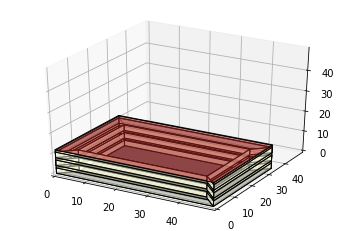

In [3]:
# Open the IDF file
building = ef.get_building("Medium_Office.idf")
building.view_model()

In [4]:
#You can convert an idf to epJSON using the following code. 
# !energyplus -c "Medium_Office.idf"

# (2) Evaluator
## Set up the inputs and outputs of your exploration

Defines how we will evaluate the building;
- what external weather conditions is the building experiencing,
- what properties of the building will we be changing, and 
- what are some of the performance metrics of the building that we want to explore.  

The weather conditions are specified in the EnergyPlus Weather File (EWP) file. The properties we will change in the building will be defined in the parameter space. In the objectives we will specify the what output performance metrics we wish to extract such that we can explore them later. 

In [5]:
# building.idfobjects

In [6]:
# for materials in building.idfobjects["MATERIAL:NOMASS"]:
#     print("{} {}".format(materials.Name,materials.Thermal_Resistance)) 

# for materials in building.idfobjects["BUILDINGSURFACE:DETAILED"]:
#     if materials.Sun_Exposure!="NoSun": print(materials.Construction_Name )
        
# for materials in building.idfobjects['CONSTRUCTION']:
#     if materials.Name=="BTAP-Ext-Wall-Mass:U-0.315": print(materials)

![Image](image/setting_up_the_evaluator.PNG) 

In [7]:
# Here we change all the external insulation of the building
insu1 = FieldSelector(class_name='MATERIAL:NOMASS', object_name='Typical Insulation 2', field_name='Thermal Resistance')


# Setup the parameters, Solar Heat Gain Coefficient
parameters = [Parameter(FieldSelector('Window',"*",'Solar Heat Gain Coefficient'),
                value_descriptor=RangeParameter(0.01,0.99),
                name='Solar Gain Coefficient'),
             Parameter(insu1,
                value_descriptor=RangeParameter(1,15),
                name='Insulation Resistance'),]


# Add window-to-wall ratio as a parameter between 0.1 and 0.9 using a custom function
parameters.append(wwr(RangeParameter(0.1, 0.9))) 


# Construct the objective
objective = ['Electricity:Facility']


# Build the problem
problem = EPProblem(parameters, objective)

In [8]:
# setup the evaluator
evaluator = EvaluatorEP(problem, building, epw_file = "victoria.epw", multi=True,
                        progress_bar=True, distributed=True, out_dir="outputdirectory")

# (3) Generate the Dataset

1. Sample the problem space
2. Setup the parallel processing
3. Generate the Samples
4. Store and recover the expensive runs

In [9]:

# Use latin hypercube sampling to take 30 samples
inputs = sampling.dist_sampler(sampling.lhs, problem,100)


# sample of the inputs
print(inputs.head())

   Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio
0                0.980214               9.160124              0.650856
1                0.661204              13.430512              0.597784
2                0.716411               4.617035              0.337802
3                0.518645               7.229073              0.677144
4                0.206976              10.194319              0.808266


In [10]:
# Setup the parallel processing in the notebook.
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:37141' processes=16 threads=16, memory=34.36 GB>

Run the samples

In [ ]:
t1=time.time()
# Run Energyplus
outputs = evaluator.df_apply(inputs)
t2=time.time()
time_of_sim=t2-t1

/usr/local/lib/python3.7/dist-packages/distributed/worker.py:3339: UserWarning: Large object of size 6.95 MB detected in task graph: 
  ("('from_pandas-10fc1b0e937cec3185233c4f9719f146', ... 33c4f9719f146')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


Calculate the time

In [ ]:
def niceformat(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds 

hours,mins,secs=niceformat(time_of_sim)

print("The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(hours,mins,secs))
# Build a results DataFrame

In [ ]:
results = inputs.join(outputs)
results.head()

## Take a look at the results

In [ ]:
total_heating_use = results['Electricity:Facility']

def norm_res(results):
    results_normed = (results - np.mean(results))/np.std(results)
    return results_normed

plt.scatter(norm_res(results['Solar Gain Coefficient']),total_heating_use,label="solar gain")
plt.scatter(norm_res(results['Window to Wall Ratio']),total_heating_use,label="w2w ratio")
plt.scatter(norm_res(results['Insulation Resistance']),total_heating_use,label="Insulation Resistance")

plt.legend()

## Store the expensive calculations

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [ ]:
inputs.to_pickle("inputs.pkl")
outputs.to_pickle("outputs.pkl")

In [10]:
inputs_ = pd.read_pickle("inputs.pkl")
outputs_ = pd.read_pickle("outputs.pkl")

# (5) Setup the dataset for the Surrogate Model 

The outputs are packed in a single columns which will not work for tensorflow.

In [11]:
print(outputs_.head())
print(inputs_.head())

   Electricity:Facility
0          1.999243e+12
1          1.966446e+12
2          1.634494e+12
3          1.604978e+12
4          1.838792e+12
   Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio
0                0.908584               4.854668              0.822617
1                0.469324              11.766597              0.798576
2                0.390397               7.866908              0.188102
3                0.367993               9.632202              0.120128
4                0.405527               9.803255              0.585378


We will repack them using the following code, to get 365 different columns which will represent the output labels. Build the full dataset with inputs and outputs to easily split up the train and test data sets. The training data sets are used to train the model, while the test data set will show how general the model is. 

In [12]:
dataset=inputs_.join(outputs_)
dataset.head()

Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio  \
0                0.908584               4.854668              0.822617   
1                0.469324              11.766597              0.798576   
2                0.390397               7.866908              0.188102   
3                0.367993               9.632202              0.120128   
4                0.405527               9.803255              0.585378   

   Electricity:Facility  
0          1.999243e+12  
1          1.966446e+12  
2          1.634494e+12  
3          1.604978e+12  
4          1.838792e+12

# Split dataset into test and training

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

training_labels = train_dataset[outputs_.columns]
testing_labels = test_dataset[outputs_.columns]
training_labels

Electricity:Facility
26          1.954075e+12
86          1.710905e+12
2           1.634494e+12
55          1.724594e+12
75          1.722192e+12
..                   ...
69          1.724147e+12
20          1.949339e+12
94          1.921412e+12
72          1.758905e+12
77          1.885642e+12

[80 rows x 1 columns]

# Normalize the Data (Inputs of the model)

We will normalize the inputs and the outputs

In [14]:
train_stats = train_dataset[inputs_.columns]
train_stats = train_stats.describe()
train_stats = train_stats.transpose()
train_stats

count      mean       std       min       25%  \
Solar Gain Coefficient   80.0  0.519140  0.269162  0.015683  0.302935   
Insulation Resistance    80.0  7.822454  4.022222  1.124960  4.420202   
Window to Wall Ratio     80.0  0.508981  0.222432  0.111234  0.332921   

                             50%        75%        max  
Solar Gain Coefficient  0.527331   0.735092   0.988500  
Insulation Resistance   7.855031  10.947344  14.994939  
Window to Wall Ratio    0.510361   0.697192   0.885781

In [15]:

# use the stats we calculated to do the normalization on the input.
def norm_input(x):
    return (x - train_stats['mean']) / train_stats['std']

def unnorm_input(x):
    return (x* train_stats['std'])+ train_stats['mean']

normed_train_data = norm_input(train_dataset[inputs_.columns])
normed_test_data = norm_input(test_dataset[inputs_.columns])


print(test_dataset[inputs_.columns].head())
print(normed_test_data.head())
print(unnorm_input(normed_test_data.head()))

    Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio
9                 0.807155               6.023020              0.465111
12                0.663061              12.758043              0.541317
21                0.865366              11.065040              0.736124
25                0.164315               1.926658              0.242456
36                0.251987               5.551554              0.330283
    Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio
9                 1.070047              -0.447373             -0.197232
12                0.534702               1.227080              0.145375
21                1.286313               0.806168              1.021179
25               -1.318257              -1.465806             -1.198237
36               -0.992535              -0.564589             -0.803388
    Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio
9                 0.807155               6.023020              0

# Normalize the labels (Outputs of the model)

labels are the actual outputs that we are interested in. 

In [16]:
train_mean = np.mean(training_labels)
train_std  = np.std(testing_labels)
train_mean, train_std

(Electricity:Facility    1.816284e+12
 dtype: float64,
 Electricity:Facility    1.433704e+11
 dtype: float64)

In [17]:
def norm_output(x):
    return (x - train_mean) /train_std

def unnorm_output(x):
    return (x*train_std)+ train_mean

train_labels = norm_output(training_labels)
test_labels  = norm_output(testing_labels)
train_labels.head()

Electricity:Facility
26              0.961087
86             -0.735008
2              -1.267970
55             -0.639533
75             -0.656285

# (5) Build & Train Surrogate model architecture 

In [18]:
def build_model():
    model = keras.Sequential([
       layers.Dense(5, input_shape=[len(train_dataset[inputs_.columns].keys())]),
       layers.Dense(5),
       layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.4908,  mae:1.5995,  mse:3.4908,  val_loss:2.8472,  val_mae:1.4809,  val_mse:2.8472,  
....................................................................................................
Epoch: 100, loss:2.4005,  mae:1.3447,  mse:2.4005,  val_loss:2.0969,  val_mae:1.2491,  val_mse:2.0969,  
....................................................................................................
Epoch: 200, loss:1.6133,  mae:1.1169,  mse:1.6133,  val_loss:1.5025,  val_mae:1.0296,  val_mse:1.5025,  
....................................................................................................
Epoch: 300, loss:1.0368,  mae:0.9047,  mse:1.0368,  val_loss:1.0345,  val_mae:0.8159,  val_mse:1.0345,  
....................................................................................................
Epoch: 400, loss:0.6570,  mae:0.7113,  mse:0.6570,  val_loss:0.7000,  val_mae:0.6246,  val_mse:0.7000,  
........................................................................

In [22]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'loss')

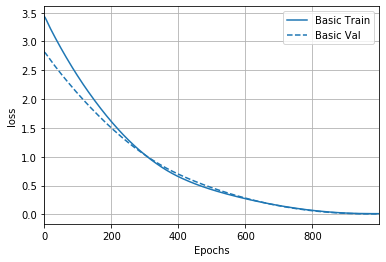

In [23]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylabel('loss')

# (6) Surrogate Model & Validate against the Test dataset

average R sqaured score: 0.9704462861305323


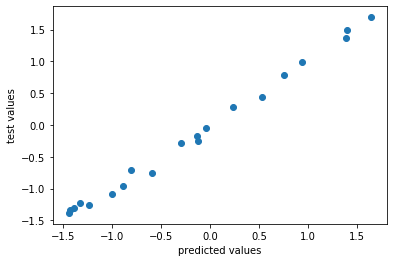

In [24]:
# See -> https://en.wikipedia.org/wiki/Coefficient_of_determination
# R squared score:
r_sqared_scores = []
sum_res_s = []
sum_tot_s = []
y_i = test_labels.loc[test_labels.index].values
y_m = np.mean(y_i)/y_i.size
for i in range(len(normed_test_data)):
    x_i = normed_test_data.loc[normed_test_data.index[i]].tolist()
    f_i = model.predict([x_i])[0]
    y_i = test_labels.loc[test_labels.index[i]].values
    ss_res=(f_i-y_i)**2
    ss_tot=(y_i-y_m)**2
    sum_res_s.append(f_i)
    sum_tot_s.append(y_i)
    r_sqared_scores.append(1-ss_res/ss_tot)

plt.scatter(sum_res_s,sum_tot_s)
plt.xlabel("predicted values")
plt.ylabel("test values")
print("average R sqaured score: {}".format(np.mean(r_sqared_scores)))

# (7) Sample Surrogate Model

In [25]:
from besos.evaluator import EvaluatorGeneric

In [26]:
def evaluation_func(ind):
    vals = norm_input(list(ind))
    output = unnorm_output(model.predict([list(vals)])[0][0])
    return ((output.values[0],),())

GP_SM = EvaluatorGeneric(evaluation_func, problem)

In [27]:
srinputs = sampling.dist_sampler(sampling.lhs, problem, 100)
sroutputs = GP_SM.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Solar Gain Coefficient  Insulation Resistance  Window to Wall Ratio  \
0                0.877723              10.328806              0.151321   
1                0.430164               6.025796              0.384092   
2                0.561125               9.407312              0.777024   
3                0.086388              14.182918              0.141822   
4                0.303898               7.201950              0.896001   

   Electricity:Facility  
0          1.602558e+12  
1          1.757320e+12  
2          1.958208e+12  
3          1.587385e+12  
4          2.037647e+12

# (8) Exploration

In [28]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [33]:
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=["Window to Wall Ratio",
                "Insulation Resistance","Solar Gain Coefficient" ,"Electricity:Facility"],
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()